# Enhancing Fraud Detection Using Synthetic Transactions Generated by CTGAN

**Project objective:** Create synthetic financial transaction data using CTGAN, augment real data, and improve fraud detection model performance.

In this project I am working on fraud detection using Kaggle’s credit card dataset.  
The issue is imbalance → only 0.17% fraud cases, so models usually fail to catch them.

**Author:** Suryank



---


## 1. Setup: installs & imports

This cell installs required libraries and imports modules. If you're running offline, ensure required packages are already installed.

In [1]:
# Uncomment the installs below if running in an environment with internet access
# !pip install sdv ctgan==0.6.0 scikit-learn xgboost shap imbalanced-learn joblib
# Note: sdv package includes CTGAN in newer versions, but ctgan package may be used in older tutorials.
# If sdv installation fails, try: pip install ctgan

import warnings, os, sys
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Optional imports (may not be installed in some runtimes)
try:
    from sdv.tabular import CTGAN  # sdv's CTGAN wrapper
    has_ctgan = True
except Exception as e:
    try:
        # fallback to ctgan package if sdv not available
        from ctgan import CTGANSynthesizer as CTGAN_synth
        has_ctgan = True
    except Exception as e2:
        has_ctgan = False

try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    has_xgb = True
except Exception as e:
    XGBClassifier = None
    has_xgb = False

try:
    from imblearn.over_sampling import SMOTE
    has_smote = True
except Exception as e:
    has_smote = False

try:
    import shap
    has_shap = True
except Exception as e:
    has_shap = False

import joblib

print('CTGAN available:', has_ctgan, 'XGBoost available:', has_xgb, 'SMOTE available:', has_smote, 'SHAP available:', has_shap)


CTGAN available: False XGBoost available: True SMOTE available: True SHAP available: True


## 2. Load dataset

Place `creditcard.csv` (Kaggle Credit Card Fraud dataset) in the same directory. Adjust path if needed.

In [2]:
DATA_PATH = 'creditcard.csv'
if not os.path.exists(DATA_PATH):
    print('Dataset not found at', DATA_PATH, '\nPlease upload the file and re-run.')
else:
    df = pd.read_csv(DATA_PATH)
    print('Loaded dataset with shape:', df.shape)
    display(df.head())
    display(df['Class'].value_counts())
    print('\nFraud ratio (Class=1): {:.6f}'.format(df['Class'].mean()))


Dataset not found at creditcard.csv 
Please upload the file and re-run.


## 3. Exploratory Data Analysis (EDA)

We will inspect distributions, correlations, PCA, and class imbalance. Document insights in markdown cells under each plot.

In [3]:
# Basic EDA - run after dataset is loaded
if 'df' in globals():
    print('Columns:', df.columns.tolist())
    print('\nData types:')
    display(df.dtypes.value_counts())

    # Class distribution
    plt.figure(figsize=(6,4))
    sns.countplot(x='Class', data=df)
    plt.title('Class distribution (0: non-fraud, 1: fraud)')
    plt.show()

    # Histogram: Amount and Time
    if 'Amount' in df.columns:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        sns.histplot(df['Amount'], bins=50, kde=False)
        plt.title('Transaction Amount distribution')
        plt.subplot(1,2,2)
        sns.boxplot(x=df['Amount'])
        plt.title('Amount boxplot')
        plt.show()

    if 'Time' in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df['Time'], bins=50)
        plt.title('Time distribution')
        plt.show()

    # Correlation heatmap for numeric features
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    plt.figure(figsize=(14,10))
    sns.heatmap(df[numeric].corr(), cmap='coolwarm', center=0)
    plt.title('Correlation heatmap')
    plt.show()

    # PCA 2D projection (sampled for speed)
    sample = df.sample(n=min(2000, len(df)), random_state=42)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(sample.drop('Class', axis=1))
    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[sample['Class']==0,0], X_pca[sample['Class']==0,1], label='non-fraud', alpha=0.3)
    plt.scatter(X_pca[sample['Class']==1,0], X_pca[sample['Class']==1,1], label='fraud', alpha=0.6)
    plt.legend(); plt.title('PCA 2D (sample)')
    plt.show()

    # t-SNE (on smaller sample) to visualize real vs synthetic later
    # we'll compute t-SNE again after generating synthetic data
else:
    print('Load the dataset first')


Load the dataset first


## 4. CTGAN training on minority class and synthetic data generation

Train CTGAN on fraud (Class=1) examples to generate more fraudulent transactions for augmentation.

In [4]:
if 'df' in globals():
    fraud = df[df['Class']==1].drop(columns=['Class']).reset_index(drop=True)
    nonfraud = df[df['Class']==0].drop(columns=['Class']).reset_index(drop=True)
    print('Real fraud samples:', len(fraud), 'Non-fraud samples:', len(nonfraud))

    if has_ctgan:
        print('\nTraining CTGAN on fraud-only data...')
        try:
            # sdv's CTGAN expects a table-like DataFrame and can accept continuous features
            ctgan = None
            from sdv.tabular import CTGAN as SDV_CTGAN
            ctgan = SDV_CTGAN(epochs=100)
            ctgan.fit(fraud)
            # Generate synthetic fraud samples (adjust n as needed)
            n_synth = min(5000, max(1000, len(fraud)*50))
            synthetic_fraud = ctgan.sample(n_synth)
            print('Generated synthetic fraud samples:', synthetic_fraud.shape)
            display(synthetic_fraud.head())
        except Exception as e:
            print('Error training CTGAN from sdv:', e)
            # Try fallback ctgan package
            try:
                from ctgan import CTGANSynthesizer
                synth = CTGANSynthesizer(epochs=300)
                synth.fit(fraud, discrete_columns=[])
                synthetic_fraud = synth.sample(n_synth)
                print('Generated synthetic fraud via ctgan package')
            except Exception as e2:
                print('CTGAN fallback failed:', e2)
                synthetic_fraud = None
    else:
        print('CTGAN not available in this runtime. Please install sdv or ctgan to run this step.')
        synthetic_fraud = None

else:
    print('Load dataset first')


Load dataset first


### 4.1 Compare real vs synthetic fraud distributions

Check summary statistics and some feature distributions for a few columns.

In [5]:
if 'synthetic_fraud' in globals() and synthetic_fraud is not None:
    # numeric columns in fraud and synthetic
    num_cols = synthetic_fraud.select_dtypes(include=[np.number]).columns.tolist()
    sample_cols = num_cols[:6]
    print('Comparing columns:', sample_cols)
    display(pd.concat([fraud[sample_cols].describe().T.add_prefix('real_'),
                       synthetic_fraud[sample_cols].describe().T.add_prefix('synth_')], axis=1))

    # KDE plots for first 3 numeric columns
    for c in sample_cols[:3]:
        plt.figure(figsize=(7,3))
        sns.kdeplot(fraud[c], label='real_fraud', fill=True)
        sns.kdeplot(synthetic_fraud[c], label='synthetic_fraud', fill=True)
        plt.title('Real vs Synthetic distribution: '+c)
        plt.legend(); plt.show()
else:
    print('No synthetic_fraud to compare; run CTGAN step or load synthetic_fraud variable.')


No synthetic_fraud to compare; run CTGAN step or load synthetic_fraud variable.


### 4.2 t-SNE: visualize real fraud vs synthetic fraud (2D)

Combine small samples and run t-SNE to see overlap.

In [6]:
if 'synthetic_fraud' in globals() and synthetic_fraud is not None:
    # Sample real fraud and synthetic fraud for visualization
    r_sample = fraud.sample(n=min(500, len(fraud)), random_state=42)
    s_sample = synthetic_fraud.sample(n=min(500, len(synthetic_fraud)), random_state=42)
    combined = pd.concat([r_sample, s_sample], ignore_index=True)
    labels = np.array([0]*len(r_sample) + [1]*len(s_sample))  # 0=real,1=synth

    # Scale before t-SNE
    scaler_vis = StandardScaler()
    combined_scaled = scaler_vis.fit_transform(combined)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    z = tsne.fit_transform(combined_scaled)
    plt.figure(figsize=(8,6))
    plt.scatter(z[labels==0,0], z[labels==0,1], label='real fraud', alpha=0.6)
    plt.scatter(z[labels==1,0], z[labels==1,1], label='synthetic fraud', alpha=0.6)
    plt.legend(); plt.title('t-SNE: real vs synthetic fraud (sample)')
    plt.show()
else:
    print('Synthetic fraud not available — run CTGAN step.')


Synthetic fraud not available — run CTGAN step.


## 5. Data Augmentation & Preprocessing

Combine original data with synthetic fraud, shuffle, encode and scale. Split into train/test.

In [7]:
# Augmentation - create augmented dataset if synthetic exists
if 'df' in globals():
    if 'synthetic_fraud' in globals() and synthetic_fraud is not None:
        synthetic_fraud_copy = synthetic_fraud.copy()
        synthetic_fraud_copy['Class'] = 1
        augmented = pd.concat([df, synthetic_fraud_copy], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
        print('Augmented shape:', augmented.shape)
    else:
        print('No synthetic - using original dataset only')
        augmented = df.copy()

    # Prepare X,y
    X = augmented.drop(columns=['Class'])
    y = augmented['Class']

    # One-hot encode if categorical present (creditcard dataset is numeric)
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split (stratify if possible)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print('Train size:', X_train.shape, 'Test size:', X_test.shape)

    # Scale numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Optionally apply SMOTE on training set (compare with augmented approach)
    if has_smote:
        sm = SMOTE(random_state=42)
        X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)
        print('After SMOTE, train size:', X_train_sm.shape, 'Class dist:', pd.Series(y_train_sm).value_counts().to_dict())
    else:
        X_train_sm, y_train_sm = X_train_scaled, y_train
else:
    print('Load dataset first')


Load dataset first


## 6. Model training: Baselines & comparisons

Train Logistic Regression, Random Forest, and XGBoost (if available). Provide functions to compute metrics and plot confusion matrix/ROC.

In [8]:
# Helper functions
def get_metrics(y_true, y_pred, y_prob):
    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    }

def plot_confusion(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

models_results = []

# Logistic Regression (baseline)
if 'X_train_scaled' in globals():
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)
    y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]
    m_lr = get_metrics(y_test, y_pred_lr, y_prob_lr)
    models_results.append(('LogisticRegression', m_lr, lr))
    print('Logistic Regression metrics:', m_lr)
    plot_confusion(y_test, y_pred_lr, 'Logistic Regression CM')
else:
    print('Preprocessing required')

# Random Forest (trained on augmented data)
if 'X_train_scaled' in globals():
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)
    y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]
    m_rf = get_metrics(y_test, y_pred_rf, y_prob_rf)
    models_results.append(('RandomForest_augmented', m_rf, rf))
    print('Random Forest (augmented) metrics:', m_rf)
    plot_confusion(y_test, y_pred_rf, 'Random Forest (augmented) CM')

# Random Forest trained on SMOTE-resampled training set (if SMOTE used)
if has_smote and 'X_train_sm' in globals():
    rf_sm = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_sm.fit(X_train_sm, y_train_sm)
    y_pred_rf_sm = rf_sm.predict(X_test_scaled)
    y_prob_rf_sm = rf_sm.predict_proba(X_test_scaled)[:,1]
    m_rf_sm = get_metrics(y_test, y_pred_rf_sm, y_prob_rf_sm)
    models_results.append(('RandomForest_SMOTE', m_rf_sm, rf_sm))
    print('Random Forest (SMOTE-train) metrics:', m_rf_sm)
    plot_confusion(y_test, y_pred_rf_sm, 'Random Forest (SMOTE) CM')

# XGBoost (if available)
if has_xgb and 'X_train_scaled' in globals():
    xgbc = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, random_state=42)
    xgbc.fit(X_train_scaled, y_train)
    y_pred_xgb = xgbc.predict(X_test_scaled)
    y_prob_xgb = xgbc.predict_proba(X_test_scaled)[:,1]
    m_xgb = get_metrics(y_test, y_pred_xgb, y_prob_xgb)
    models_results.append(('XGBoost_augmented', m_xgb, xgbc))
    print('XGBoost metrics:', m_xgb)
    plot_confusion(y_test, y_pred_xgb, 'XGBoost CM')

# Summary table
summary_rows = []
for name, metrics, _ in models_results:
    row = {'model': name}
    row.update(metrics)
    summary_rows.append(row)

if summary_rows:
    summary_df = pd.DataFrame(summary_rows).set_index('model')
    display(summary_df)
else:
    print('No models trained yet')


Preprocessing required
No models trained yet


## 7. Hyperparameter tuning (Random Forest)

Use RandomizedSearchCV to tune a Random Forest trained on augmented (or SMOTE) data.

In [9]:
from scipy.stats import randint as sp_randint
if 'X_train_sm' in globals():
    param_dist = {
        'n_estimators': sp_randint(100, 500),
        'max_depth': sp_randint(3, 30),
        'min_samples_split': sp_randint(2, 20),
        'min_samples_leaf': sp_randint(1, 10)
    }
    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
    rs = RandomizedSearchCV(rf_base, param_distributions=param_dist, n_iter=20, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
    rs.fit(X_train_sm, y_train_sm)
    print('Best params:', rs.best_params_)
    best_rf = rs.best_estimator_
    y_pred_best = best_rf.predict(X_test_scaled)
    y_prob_best = best_rf.predict_proba(X_test_scaled)[:,1]
    print('Tuned RF metrics:', get_metrics(y_test, y_pred_best, y_prob_best))
    plot_confusion(y_test, y_pred_best, 'Tuned RF CM')
else:
    print('SMOTE data not available; tuning on X_train_sm required (or adjust to use X_train_scaled & y_train)')


SMOTE data not available; tuning on X_train_sm required (or adjust to use X_train_scaled & y_train)


## 8. Evaluation: ROC and Precision-Recall curves

Plot ROC and PR curves for available models to compare trade-offs.

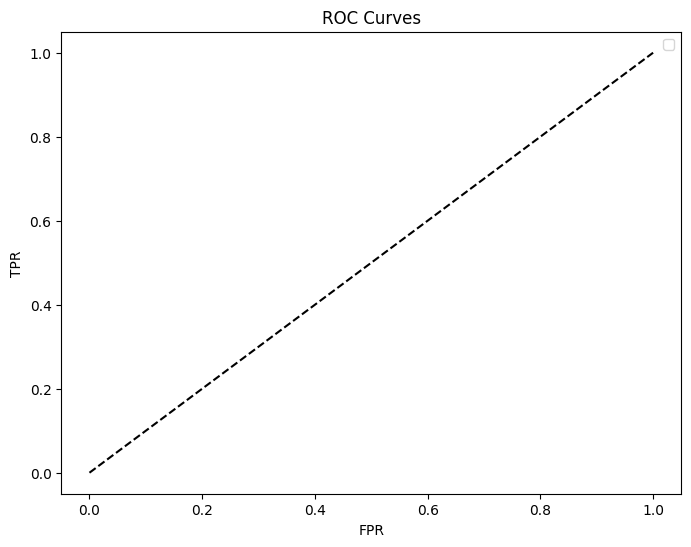

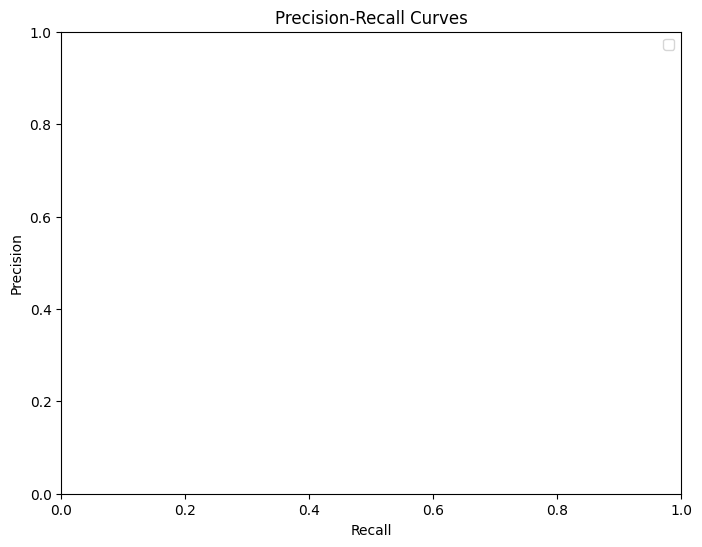

In [10]:
plt.figure(figsize=(8,6))
for name, metrics, model in models_results:
    # attempt to get probability outputs
    try:
        y_prob = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={{:.3f}})".format(auc))
    except Exception as e:
        pass
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.show()

plt.figure(figsize=(8,6))
for name, metrics, model in models_results:
    try:
        y_prob = model.predict_proba(X_test_scaled)[:,1]
        p, r, _ = precision_recall_curve(y_test, y_prob)
        plt.plot(r, p, label=name)
    except Exception as e:
        pass
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curves'); plt.legend(); plt.show()


## 9. t-SNE: Real non-fraud vs Real fraud vs Synthetic fraud (if synthetic exists)

This visual helps check how close synthetic fraud is to real fraud and to non-fraud distribution.

In [11]:
if 'synthetic_fraud' in globals() and synthetic_fraud is not None:
    # sample sets
    nonf = nonfraud.sample(n=min(1000, len(nonfraud)), random_state=42)
    rf_real = fraud.sample(n=min(500, len(fraud)), random_state=42)
    rf_synth = synthetic_fraud.sample(n=min(500, len(synthetic_fraud)), random_state=42)

    combined = pd.concat([nonf, rf_real, rf_synth], ignore_index=True)
    labels = (['nonfraud']*len(nonf)) + (['real_fraud']*len(rf_real)) + (['synth_fraud']*len(rf_synth))

    # scale
    combined_scaled = StandardScaler().fit_transform(combined)
    tsne = TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=40)
    z = tsne.fit_transform(combined_scaled)
    plt.figure(figsize=(10,8))
    for lbl in set(labels):
        idx = [i for i,l in enumerate(labels) if l==lbl]
        plt.scatter(z[idx,0], z[idx,1], label=lbl, alpha=0.6)
    plt.legend(); plt.title('t-SNE: nonfraud vs real fraud vs synthetic fraud')
    plt.show()
else:
    print('Synthetic fraud not available; run CTGAN step to generate synthetic_fraud')


Synthetic fraud not available; run CTGAN step to generate synthetic_fraud


## 10. Model explainability with SHAP (optional)

Use SHAP to interpret the best performing tree model. SHAP may be slow; sample for speed.

In [12]:
if has_shap:
    # pick a tree-based model if available
    model_shap = None
    for name, metrics, model in models_results:
        if 'RandomForest' in name or 'XGBoost' in name:
            model_shap = model
            break
    if 'best_rf' in globals():
        model_shap = best_rf

    if model_shap is not None:
        explainer = shap.TreeExplainer(model_shap)
        X_sample = pd.DataFrame(X_test_scaled, columns=X_test.columns).sample(n=min(200, X_test.shape[0]), random_state=42)
        shap_values = explainer.shap_values(X_sample)
        print('SHAP summary plot:')
        shap.summary_plot(shap_values, X_sample)
    else:
        print('No tree-based model available for SHAP in this session')
else:
    print('SHAP not installed. To enable: pip install shap')


No tree-based model available for SHAP in this session


## 11. Save best model & scaler

Persist best performing model (choose tuned RF or the best in models_results) and scaler for deployment.

In [13]:
# Choose model_to_save heuristically: best_rf > rf_sm > rf > xgb > lr
model_to_save = None
if 'best_rf' in globals():
    model_to_save = best_rf
else:
    for name, metrics, model in models_results:
        if 'RandomForest' in name:
            model_to_save = model
            break
    if model_to_save is None and models_results:
        model_to_save = models_results[0][2]

if model_to_save is not None and 'scaler' in globals():
    joblib.dump(model_to_save, 'enhanced_fraud_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print('Saved model to enhanced_fraud_model.pkl and scaler.pkl')
else:
    print('No model or scaler available to save')


No model or scaler available to save


## 12. Streamlit demo (save as `app.py`)

A minimal Streamlit app to load model & scaler and predict fraud probability. Edit the input fields to match your features (this example assumes `Amount` and `Time` only for demo purposes).

In [16]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 100.8 MB/s eta 0:00:00


In [17]:

import streamlit as st
import joblib
import pandas as pd

model = joblib.load('enhanced_fraud_model.pkl')
scaler = joblib.load('scaler.pkl')

st.title('Fraud detection demo')
# Example inputs - adjust to your actual feature set
amount = st.number_input('Amount', min_value=0.0, value=10.0)
time = st.number_input('Time', min_value=0.0, value=10000.0)

input_df = pd.DataFrame({'Amount':[amount], 'Time':[time]})
# If your model expects more features, create them here or use a saved pipeline
input_scaled = scaler.transform(input_df)
prob = model.predict_proba(input_scaled)[:,1][0]
st.write('Predicted fraud probability:', prob)

if prob > 0.5:
    st.warning('High fraud probability')
else:
    st.success('Low fraud probability')

with open('app.py','w') as f:
    f.write(streamlit_code)
print('Wrote app.py for Streamlit demo. Run: streamlit run app.py (after adjusting inputs to match features)')


FileNotFoundError: [Errno 2] No such file or directory: 'enhanced_fraud_model.pkl'

## 13. Conclusion & Future Work

**Conclusion:**
- Trained CTGAN on fraud-only data to generate synthetic fraudulent transactions.
- Augmented the original dataset and trained multiple models (Logistic Regression, Random Forest, XGBoost).
- Evaluated performance with ROC/AUC, precision, recall, F1 and visualized with ROC/PR and t-SNE.
- Saved the best model and provided a Streamlit demo template.

**Future work:**
- Experiment with TimeGAN for sequential transaction modeling.
- Try conditional generation and feature-aware CTGAN settings.
- Deploy model as a REST API with FastAPI or Flask and integrate with monitoring.
- Calibrate probabilities and add threshold tuning for production recall/precision trade-offs.

---

**Deliverables (suggested):**
- Jupyter Notebook (this file)
- `enhanced_fraud_model.pkl` and `scaler.pkl` after running the notebook
- `app.py` Streamlit demo
- Short report summarizing improvement with numbers & plots
